In [9]:
# import necessary dependencies
import numpy as np
import pandas as pd
from pandas.api.types import is_datetime64_any_dtype as is_datetime
import os, warnings, math
import gc # module for optional garbage collection
gc.enable() #Enable automatic garbage collection.
import time
import random
import holidays

import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

import seaborn as msns; sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

import matplotlib.patches as patches
import seaborn as sns
from datetime import date

In [3]:
# notebook project directories
base_dir = '/home/prayush/bj/energy_predictor'
input_dir = os.path.join(base_dir, 'input')
checkpoint_dir = os.path.join(base_dir, 'checkpoints')
plot_dir = os.path.join(base_dir, 'plots')
output_dir = os.path.join(base_dir, 'output')
os.system("mkdir -p {} {} {} {}".format(base_dir, checkpoint_dir,plot_dir, output_dir))

0

## Load Data

In [31]:
merged_train_df = pd.read_hdf(os.path.join(input_dir,
                             "merged_train_df_no1099_steam_no778_chilledwater_no1088_chilledwater.hdf"))

In [22]:
merged_train_df.columns.values

array(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'epoch', 'primary_use_key'], dtype=object)

In [20]:
holidays_within_range=[str(date[0]) for date in holidays.UnitedStates(years = [2016, 2017, 2018, 2019]).items()]


In [21]:
holidays_within_range

['2016-01-01',
 '2016-01-18',
 '2016-02-15',
 '2016-05-30',
 '2016-07-04',
 '2016-09-05',
 '2016-10-10',
 '2016-11-11',
 '2016-11-24',
 '2016-12-25',
 '2016-12-26',
 '2017-01-01',
 '2017-01-02',
 '2017-01-16',
 '2017-02-20',
 '2017-05-29',
 '2017-07-04',
 '2017-09-04',
 '2017-10-09',
 '2017-11-11',
 '2017-11-10',
 '2017-11-23',
 '2017-12-25',
 '2018-01-01',
 '2018-01-15',
 '2018-02-19',
 '2018-05-28',
 '2018-07-04',
 '2018-09-03',
 '2018-10-08',
 '2018-11-11',
 '2018-11-12',
 '2018-11-22',
 '2018-12-25',
 '2019-01-01',
 '2019-01-21',
 '2019-02-18',
 '2019-05-27',
 '2019-07-04',
 '2019-09-02',
 '2019-10-14',
 '2019-11-11',
 '2019-11-28',
 '2019-12-25']

In [32]:

le = LabelEncoder()
merged_train_df.primary_use = le.fit_transform(merged_train_df.primary_use)

In [33]:
def prepare_data(X, test=False):
    """
    Preparing final dataset with all features.
    """
    
    X.timestamp = pd.to_datetime(X.timestamp, format="%Y-%m-%d %H:%M:%S")
    
    if not test:
        X.sort_values("timestamp", inplace=True)
        X.reset_index(drop=True, inplace=True)
    
    gc.collect()
    
    holidays = holidays_within_range
    
    X["hour"] = X.timestamp.dt.hour
    X["weekday"] = X.timestamp.dt.weekday
    X["is_holiday"] = (X.timestamp.dt.date.astype("str").isin(holidays)).astype(int)
    
    drop_features = ["timestamp", "sea_level_pressure", "wind_direction", "wind_speed", 'epoch', 'primary_use_key']

    X.drop(drop_features, axis=1, inplace=True)

    if test:
        row_ids = X.row_id
        X.drop("row_id", axis=1, inplace=True)
        return X, row_ids
    else:
        y = np.log1p(X.meter_reading)
        X.drop("meter_reading", axis=1, inplace=True)
        return X, y

In [34]:
X_train, y_train = prepare_data(merged_train_df)

gc.collect()

34

### 2fold LGBM

In [35]:
X_half_1 = X_train[:int(X_train.shape[0] / 2)]
X_half_2 = X_train[int(X_train.shape[0] / 2):]

y_half_1 = y_train[:int(X_train.shape[0] / 2)]
y_half_2 = y_train[int(X_train.shape[0] / 2):]

categorical_features = ["building_id", "site_id", "meter", "primary_use", "hour", "weekday"]

d_half_1 = lgb.Dataset(X_half_1, label=y_half_1, categorical_feature=categorical_features, free_raw_data=False)
d_half_2 = lgb.Dataset(X_half_2, label=y_half_2, categorical_feature=categorical_features, free_raw_data=False)

watchlist_1 = [d_half_1, d_half_2]
watchlist_2 = [d_half_2, d_half_1]

params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 40,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse"
}

print("Building model with first half and validating on second half:")
model_half_1 = lgb.train(params, train_set=d_half_1, num_boost_round=1000, valid_sets=watchlist_1, verbose_eval=200, early_stopping_rounds=200)

print("Building model with second half and validating on first half:")
model_half_2 = lgb.train(params, train_set=d_half_2, num_boost_round=1000, valid_sets=watchlist_2, verbose_eval=200, early_stopping_rounds=200)

Building model with first half and validating on second half:
Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 0.916244	valid_1's rmse: 1.32789
[400]	training's rmse: 0.863554	valid_1's rmse: 1.32656
Early stopping, best iteration is:
[263]	training's rmse: 0.892302	valid_1's rmse: 1.32458
Building model with second half and validating on first half:
Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 0.899503	valid_1's rmse: 1.50123
[400]	training's rmse: 0.849477	valid_1's rmse: 1.49692
[600]	training's rmse: 0.827617	valid_1's rmse: 1.49529
[800]	training's rmse: 0.807385	valid_1's rmse: 1.49475
Early stopping, best iteration is:
[746]	training's rmse: 0.813257	valid_1's rmse: 1.49424


## Feature Importance

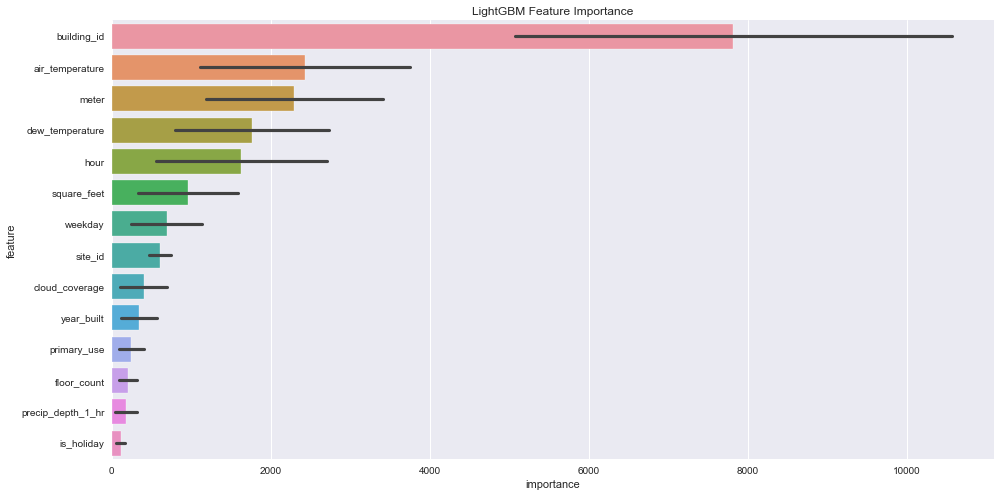

In [36]:
df_fimp_1 = pd.DataFrame()
df_fimp_1["feature"] = X_train.columns.values
df_fimp_1["importance"] = model_half_1.feature_importance()
df_fimp_1["half"] = 1

df_fimp_2 = pd.DataFrame()
df_fimp_2["feature"] = X_train.columns.values
df_fimp_2["importance"] = model_half_2.feature_importance()
df_fimp_2["half"] = 2

df_fimp = pd.concat([df_fimp_1, df_fimp_2], axis=0)

plt.figure(figsize=(14, 7))
sns.barplot(x="importance", y="feature", data=df_fimp.sort_values(by="importance", ascending=False))
plt.title("LightGBM Feature Importance")
plt.tight_layout()